In [1]:
import pandas as pd
import geopandas as gpd
import geodatasets
import h3pandas
import rasterstats
import matplotlib.pyplot as plt
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio import transform
from rasterio.plot import show
import rioxarray
import xarray
import tszip
import numpy as np
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import importlib
importlib.reload(tct)

<module 'terracotta' from '/Users/jameskitchens/Documents/GitHub/terracotta/terracotta/__init__.py'>

In [2]:
gdf = gpd.read_file(geodatasets.get_url("naturalearth land"))
gdf = gdf.loc[112:112]
resolution = 2
gdf_h3 = gdf.h3.polyfill_resample(resolution)
gdf_h3 = gdf_h3.reset_index()
gdf_h3["deme"] = gdf_h3.index

#gdf_h3.plot()
#plt.axis("off")
#plt.savefig("images/antimeridian_error.png")
#plt.show()

gdf_h3.explore()

In [3]:
gdf_h3 = gdf_h3.drop([606, 777, 78, 62, 805, 497, 811, 428]) #drop these because of antimeridian

#gdf_h3.plot()
#plt.axis("off")
#plt.savefig("images/antimeridian_solution.png")
#plt.show()

gdf_h3.explore()

/opt/anaconda3/envs/terracotta/lib/python3.12/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


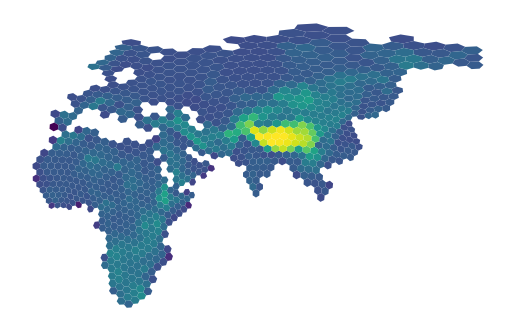

In [4]:
xds = xarray.open_dataset("ETOPO2v2c_f4.nc")
xds["z"].rio.to_raster("world_elevation.tif")

with rasterio.open("world_elevation.tif") as src_dst:
    with WarpedVRT(
        src_dst,
        src_crs=src_dst.gcps[1],
        src_transform=transform.from_gcps(src_dst.gcps[0]),
    ) as vrt:
        mean_elev = []
        for stat in rasterstats.zonal_stats(
            gdf_h3,
            vrt.read(1),
            affine=vrt.transform,
            stats="mean"
        ):
            mean_elev.append(stat["mean"])
        gdf_h3["mean_elev"] = mean_elev

gdf_h3.plot(column="mean_elev")
plt.axis("off")
plt.savefig("images/elevation_by_deme.png")
plt.show()

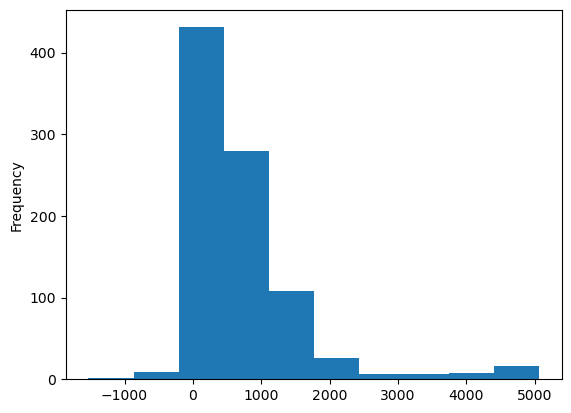

In [5]:
gdf_h3["mean_elev"].plot.hist()
plt.savefig("images/histogram_of_mean_elevations.png")
plt.show()

In [6]:
bins = [-10000, 3000, 8000]
gdf_h3["binned_elev"] = np.searchsorted(bins, gdf_h3["mean_elev"].values)

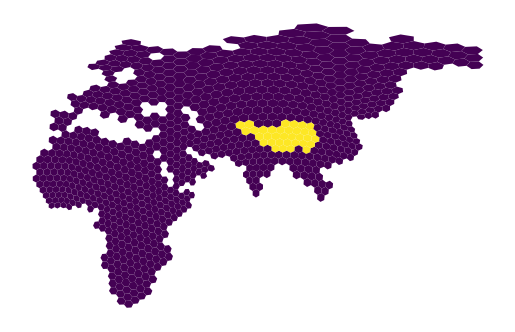

In [7]:
gdf_h3.plot(column="binned_elev")
plt.axis("off")
#plt.savefig("images/binned_elevation_by_deme.png")
plt.show()

In [8]:
sample_locs = pd.read_csv("sample_locations.csv")
sample_locs = gpd.GeoDataFrame(sample_locs, geometry=gpd.GeoSeries.from_xy(sample_locs["lon"], sample_locs["lat"]), crs=4326)
sample_locs.explore()

In [9]:
sample_locs_with_region = gpd.sjoin(sample_locs, gdf_h3, how="inner", predicate="within").loc[:, ["id", "deme"]]
#sample_locs_with_region = sample_locs_with_region.drop_duplicates("deme")
regions_with_samples = sample_locs_with_region["deme"].unique()

In [10]:
gdf_h3["geometry"] = gdf_h3.buffer(0.1)
with open("demes_elev_two_type.tsv", "w") as outfile:
    outfile.write("id\txcoord\tycoord\ttype\tneighbours\n")
    for i, row in gdf_h3.iterrows():
        neighbors = np.array(gdf_h3[gdf_h3.geometry.touches(row['geometry'])].deme)
        #overlapping neighbors use if discrepances found with touches
        overlap = np.array(gdf_h3[gdf_h3.geometry.overlaps(row['geometry'])].deme)
        neighbors = [str(d) for d in np.sort(np.union1d(neighbors, overlap))]
        center = row["geometry"].centroid
        outfile.write(f"{row["deme"]}\t{center.x}\t{center.y}\t{row["binned_elev"]-1}\t{",".join(neighbors)}\n")

/var/folders/q8/b10jdgls4xvcv3wz767kf6f80000gn/T/ipykernel_1809/1284224074.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_h3["geometry"] = gdf_h3.buffer(0.1)


In [11]:
ts = tszip.load("hgdp_tgp_sgdp_high_cov_ancients_chr17_p.dated.trees.tsz")
ts, map_nodes = ts.simplify(samples=sample_locs_with_region["id"], map_nodes=True)
sample_locs_with_region["orig_id"] = sample_locs_with_region["id"]
sample_locs_with_region["id"] = map_nodes[sample_locs_with_region["id"]]
sample_locs_with_region.to_csv("samples_two_type.tsv", sep="\t", index=False)

In [14]:
demes = pd.read_csv("demes.tsv", sep="\t")
samples = pd.read_csv("samples.tsv", sep="\t")
world_map = tct.WorldMap(demes, samples)

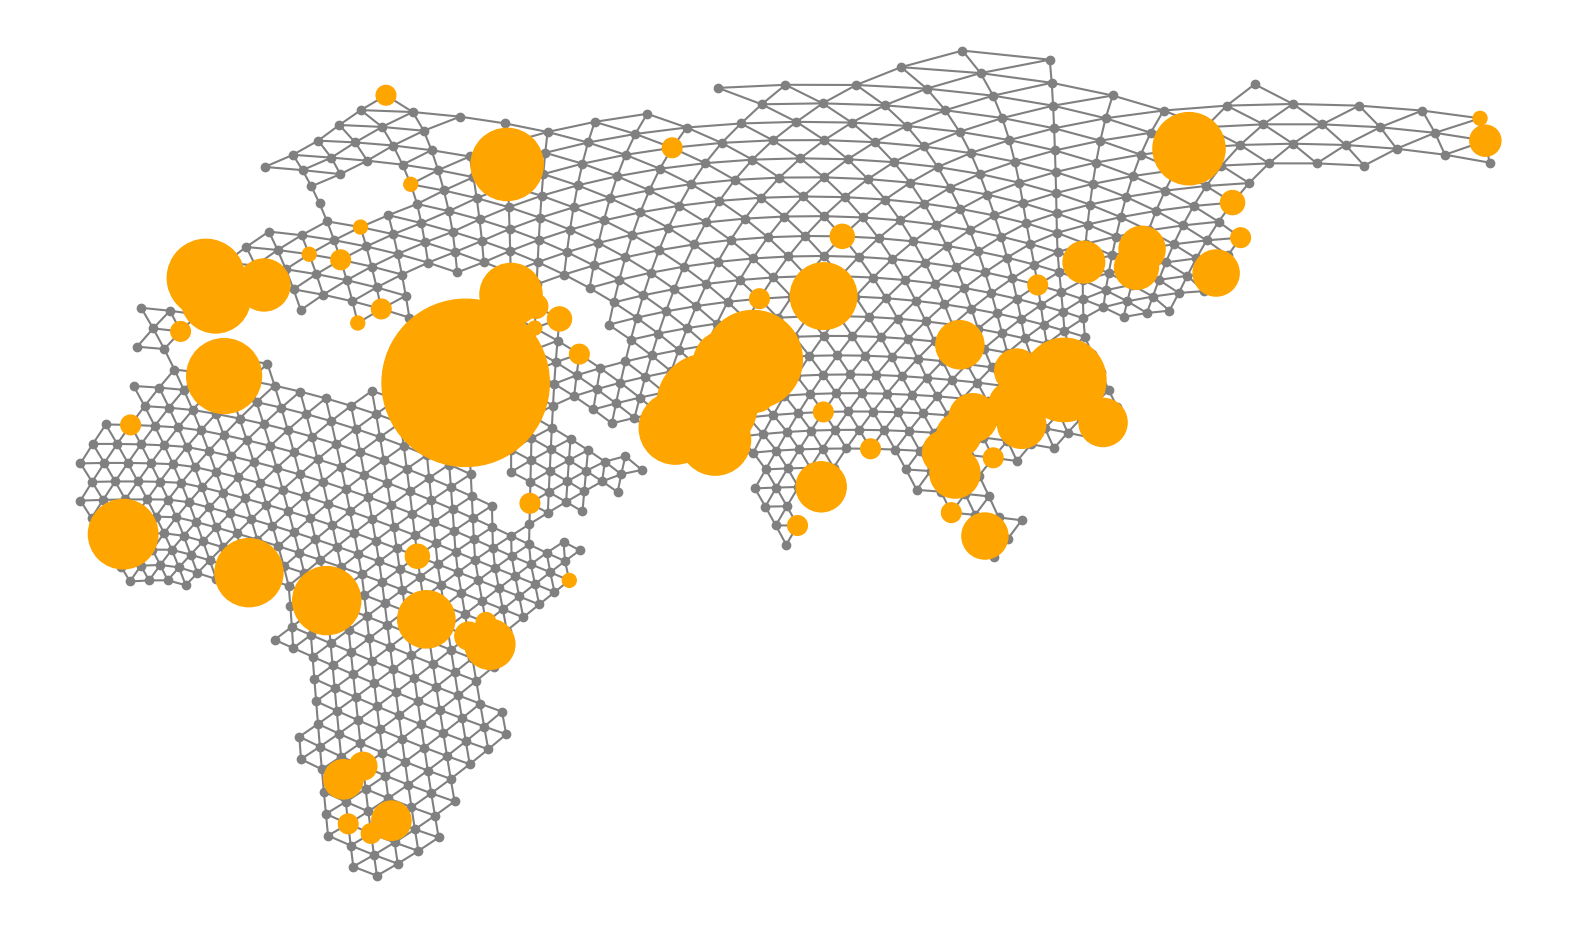

In [15]:
world_map.draw(figsize=(20,20), show_samples=True, save_to="images/terracotta_world_map.png")

In [16]:
connections = []
deme_types = range(world_map.demes["type"].max()+1)
for i,type0 in enumerate(deme_types):
    for type1 in deme_types[i:]:
        connections.append(f"{type0}-{type1}")
counts = world_map.connections["type"].value_counts().sort_index()
pd.DataFrame(connections, columns=["connection"]).join(counts)

,connection,count
0,0-0,1014
1,0-1,71
2,0-2,9
3,0-3,385
4,0-4,7
5,1-1,261
6,1-2,43
7,1-3,222
8,1-4,20
9,2-2,6


In [17]:
from os import mkdir

def create_trees_folder_from_ts(ts, output_path=".", gap_between_trees=1, discretize_time=False):
    mkdir(f"{output_path}/trees")
    for i in range(0, ts.num_trees, gap_between_trees):
        tree = ts.at_index(i)
        interval = tree.interval
        single_tree_ts = ts.keep_intervals([interval], simplify=True).trim()
        single_tree_ts.dump(f"{output_path}/trees/{i}.trees")
        #if discretize_time != False:
        #    discretized_ts = tct.nx_bin_ts(single_tree_ts, discretize_time)
        #    discretized_ts.dump(f"{output_path}/trees/{i}.trees")
        #else:
        #    single_tree_ts.dump(f"{output_path}/trees/{i}.trees")

create_trees_folder_from_ts(
    ts=ts,
    gap_between_trees=1000
)

In [22]:
import tskit
print(tskit.load("trees/0.trees").draw_text())

100000.00┊                                                                                                                     90                                                                                                          ┊   
         ┊             ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━┳━━━┳━━━━━━━━━━┳━━━━━━━━┳━━┳━━┓ ┊   
10000.00 ┊            87                           88                ┃                                    83                                      ┃                     84                       ┃    89   ┃  86         85        ┃  ┃  ┃ ┊   
         ┊ ┏━━┳━━┳━━┳━━╋━━┳━━┳━━┳━━┓ ┏━━┳━━┳━━┳━━┳━━╋━━┳━━┳━━┳━━┳━━┓ ┃ ┏━┳━┳━━┳━━━━┳━━━┳━━┳━━━━━┳━━━━━┳━━┳━┻━┳━━━━┳━━┳━━┳━━┳━━┳━━┳━━┳━━┳━━┳━━┳━━┓ ┃ ┏━━┳━━━━┳━━┳━━┳━━┳━━┳┻━┳━━┳━━┳━━┳━━┳━━┳━━┓   ┃   ┏━┻┓  ┃  ┏┻━┓  ┏━━┳━━╋━━┳━━┓  ┃  ┃  ┃ ┊   
1000.00  ┊ ┃  ┃  ┃  ┃  ┃  ┃  ┃  ┃  ┃ ┃  